# Digitizers

Digitizers convert analogue data to digital data, this is achieved using an anaglogue-to-digital converter (ADC). Generally seismographs will continiously measure voltage associated with the movement of a mass, or force exerted to keep a mass stationary (in the case of force-balance seismographs). This continuous, analogue voltage is then converted to *counts* by a digitizer and recorded to disk, or transitted via some telemetry system to a data centre.

The main role of the digitizer therefore is to convert analogue voltages to digital counts. The **Nyquist-Shanon sampling theorum** states that: *If a function x(t) contains no frequencies higher than B hertz, it is completely determined by giving its ordinates at a series of points spaced 1/(2B) seconds apart.*
It is therefore possible to select a sampling frequency such that continuous data can be recreated by digital data. However, in practice, this idealised sampling frequency is rarely used in seismology due to the possible range of frequencies generated by earthquakes or other seismic sources coupled with the long-durations of recording.

This gives rise to the idea of a **Nyquist frequency**. This is the minimum rate at which a signal can be sampled without introducing errors, which is twice the highest frequency present in the signal. Thus, if you want to faithfully represent data up to 50Hz you must sample your data at at-least 100Hz (or a sample interval of 0.01s). This is a common sampling rate for regional earthquake seismology. We will think about how the frequency content of earthquake waveforms changes with distance when we think about attenuation.

In [1]:
# Set up notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from obspy import read

plt.style.use('ggplot')

def decimate_and_plot(x, y, decimation_factors=[1, 10, 100, 200]):
    """Decimate data and plot it."""
    fig, ax = plt.subplots(1, figsize=(15, 8))
    for decimation_factor in [1, 10, 100, 200]:
        ax.plot(x[::decimation_factor], y[::decimation_factor],
                label="Decimation factor {0}".format(decimation_factor))
    legend = fig.legend()

Lets see how our choice of sampling-rate affects the signal that we record. We will start with a simple sine-wave and vary the sampling frequency.

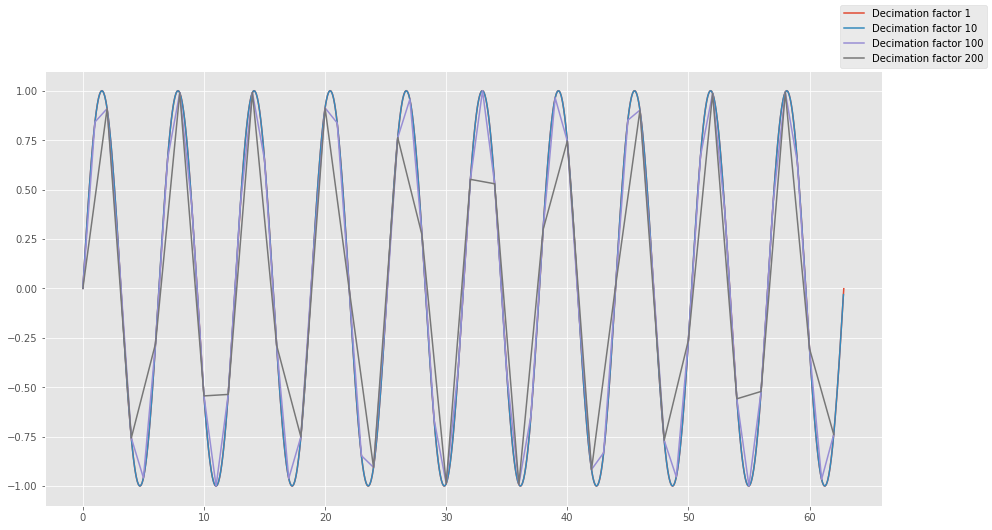

In [2]:
x = np.arange(0.0, 20 * np.pi, 0.01)
y = np.sin(x)
decimate_and_plot(x, y)

What about a slightly more interesting signal? Here we add in a second sine wave at twice the originals frequency. You can see that we lose fidelity with higher decimation factors. Higher decimation factors equal lower sampling frequencies.

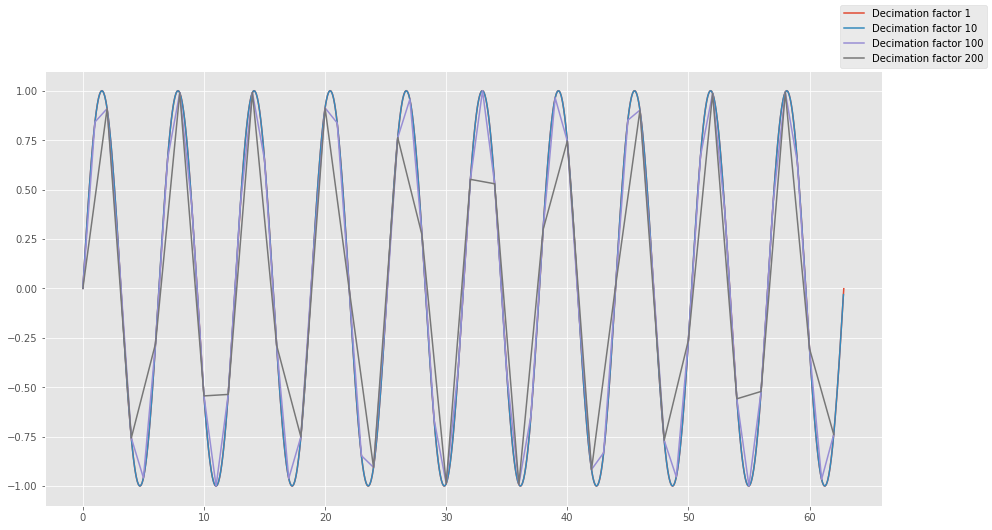

In [3]:
y_summed = y + np.sin(x * 2)
decimate_and_plot(x, y)

Lets have a look at what this will look like for real seismic data - obspy's `read` function has a default stream to read in, lets look at that.

3 Trace(s) in Stream:
BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


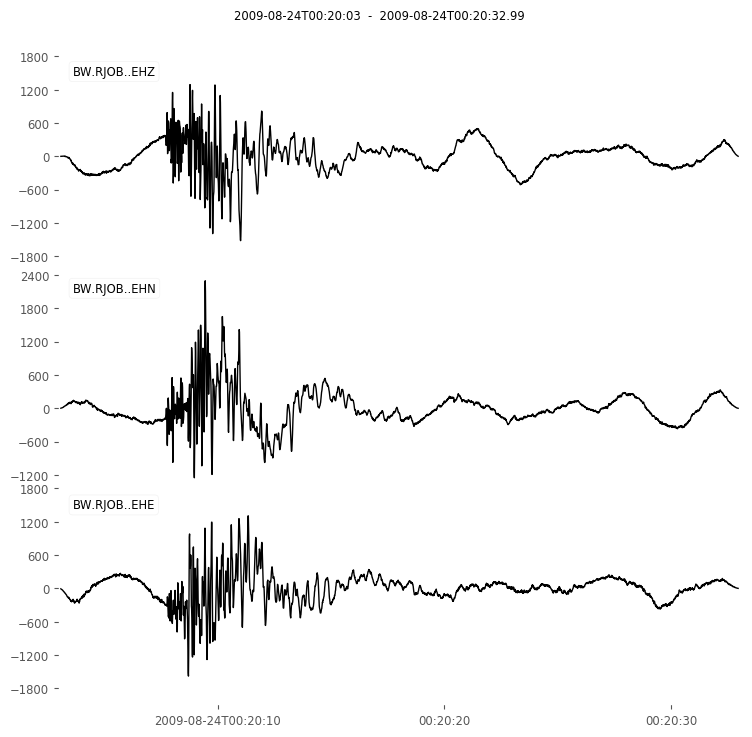

In [4]:
st = read()
print(st)
fig = st.plot()

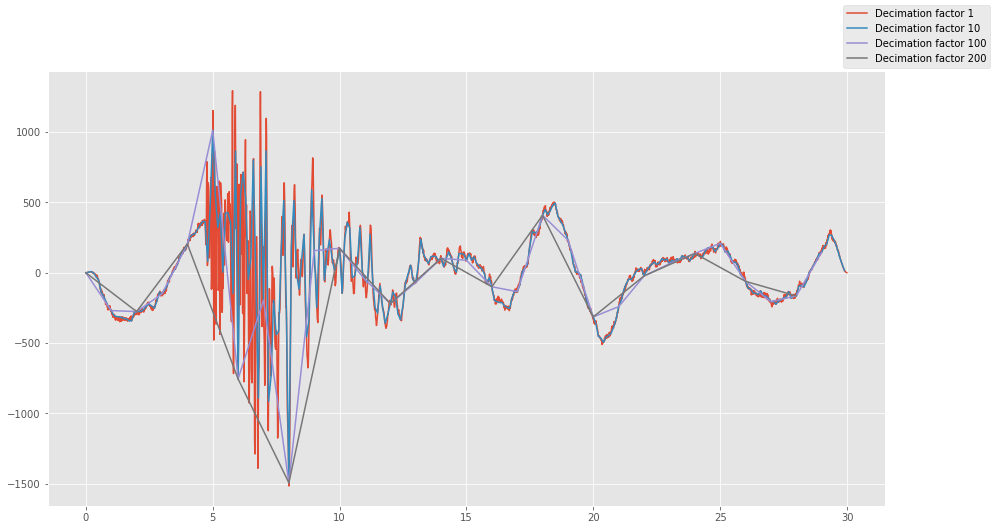

In [5]:
tr = st[0]
x = np.arange(0, tr.stats.npts * tr.stats.delta, tr.stats.delta)
y = tr.data
decimate_and_plot(x, y)

Clearly we lose fidelity very quickly, losing the high-frequencies more quickly. We will think about what frequencies these data contain in the next notebook. You should experiment with other decimation factors between 1 and 20.

In [6]:
# Play with other decimation factors between 1-20.

Obspy `Stream`s and `Trace`s also have convenience `decimate` methods for decimation by integer factors. Like most methods on obspy objects, this works in place (it changes the original data), so if you want to keep the old data you should work on a copy of the data (e.g. run `st2 = st.copy()` and work on `st2`).

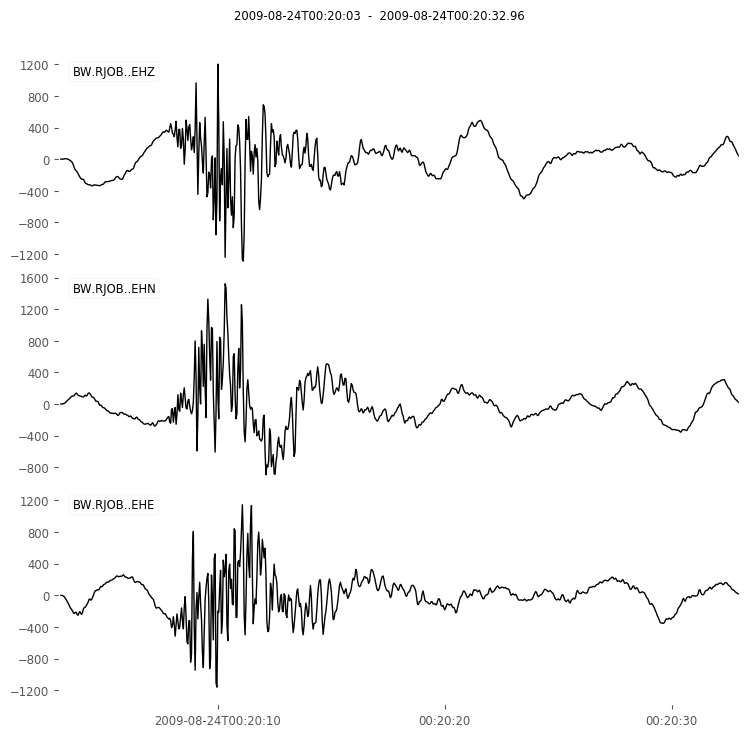

In [7]:
st.decimate(4)
fig = st.plot()

## How digitizers stabalise ADC

So we can see that chosing the correct sampling frequency for our signal is important. A key thing to remember is that if you chose too low of a sampling frequency, you will never be able to recover
information at frequencies above your Nyquist.  However, when chosing sampling frequencies you need
to consider the volume of data that that site will generate. If data are being recorded locally and
collected periodicly, then is your data disk large enough? If the data are telemetered out, how much
extra cost will be associated with a higher samping rate? 

In general, modern (as of 2019) seismographs for monitoring earthquakes rarely record at 
frequencies higher than 200Hz, and often at 100Hz (GeoNet in New Zealand uses 100Hz). 
The exception to this is when the seismometer is close to the source.

**Question:** Why do you think you would use higher sampling rates when close to the seismic source?

Decimating data can introduce aliasing, where frequencies above the Nyquist are incorrectly mapped
below the Nyquist.  We observed this when decimating the summed sine-waves: only one peak was maintained,
but with a wider period than previously. Data that are aliased can obscure the true ground motion, and
are dificult to remove.  To avoid aliasing when digitizing seismic data, digitizers usually use the
following flow:
1. Amplify analogue data (apply linear gain, often either x1 or x32);
2. Apply an Analog Anti-Aliasing (AAA) filter;
3. Digitial Oversampling of the data at a higher frequency than desired;
4. Apply a Digital Anti-Aliasing (DAA) filter;
5. Decimate.

The initial AAA filter applies a low-pass filter to the raw analog data, and generally tried to maintain
the broadest pass-band possible while reducing aliasing due to the oversampling step.  The additional
steps of oversampling and applying the DAA are done because digitial filters can generlaly have steeper
roll-offs (providing a wider passband) and AAA filters.  The DAA filter is commonly refered to as a
Finite Impulse Response (FIR) filter.  FIR filters maintain the shape of the pre-filtered
signal, but can introduce spurious acasual (before the signal) noise.  There is a tradeoff between
causal filters, which maintain the phase, and acausal filters that maintain shape. See Figure 6.6-13
of Stein and Wysession for a nice example.

**Key Point:** If decimating data, you should apply a low-pass filter prior to decimating to avoid 
aliasing.

Archived seismic data is (if done properly) associated with response information.  The standard way
of recording instrument response in data centres is using SEED, or more recetly using stationXML format.
However, other ways of recording this information are available. A compact representation of the 
seismometer response is using Poles and Zeros, which we will talk about in the 
[filtering notebook](4_Filtering_Resampling.ipynb).  The below example shows a few different 
representations of instrument response:

In [8]:
# Set up for this section.
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

client = Client("GEONET")
inventory = client.get_stations(
    network="NZ", station="JCZ", channel="HHZ", location="10",
    level="response")
print(inventory)
for channel in inventory[0][0]:
    print(channel)

Inventory created at 2019-02-28T21:32:51.000000Z
	Created by: Delta
		    
	Sending institution: GeoNet (WEL(GNS_Test))
	Contains:
		Networks (1):
			NZ
		Stations (1):
			NZ.JCZ (Jackson Bay)
		Channels (3):
			NZ.JCZ.10.HHZ (3x)
Channel 'HHZ', Location '10' 
	Time range: 2004-06-23T04:20:00.000000Z - 2004-10-15T00:00:00.000000Z
	Latitude: -44.07, Longitude: 168.79, Elevation: 1062.0 m, Local Depth: 0.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: -90.00 degrees down from horizontal
	Channel types: CONTINUOUS, GEOPHYSICAL
	Sampling Rate: 100.00 Hz
	Sensor (Description): Broadband Seismometer (CMG-3ESP)
	Response information available
Channel 'HHZ', Location '10' 
	Time range: 2004-10-15T01:00:00.000000Z - 2017-03-15T03:15:00.000000Z
	Latitude: -44.07, Longitude: 168.79, Elevation: 1062.0 m, Local Depth: 0.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: -90.00 degrees down from horizontal
	Channel types: CONTINUOUS, GEOPHYSICAL
	Sampling Rate: 100.00 Hz
	Sensor (Descript

This gives us a network with one station (JCZ, in Jacksons Bay), and three channels.  This tells us
that three sensors have been active at this site at different times. It is worth remembering that
seismometers can be changed and you should ensure the response information you have is correct for
the data-period you are looking at.

Lets look at the response information for the most recent sensor:

No handles with labels found to put in legend.


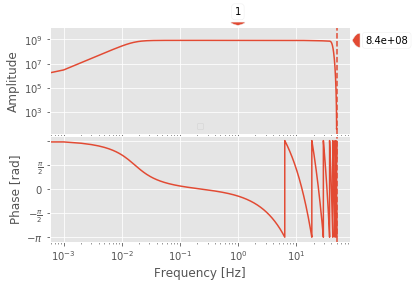

In [9]:
channel = inventory.select(starttime=UTCDateTime(2019, 1, 1))[0][0][0]
fig = channel.plot(min_freq=0.001)

The above plot shows the amplitude and phase response for this seismograph. The Nyquist is marked
by a dashed line.  Note that we have to set a minimum frequency because of the log-scale in frequency,
this response extends to 0Hz (DC).

The response is quite smooth until about 9Hz, when, in the phase response, we start to see sharp
steps. In the amplitude response we see a sharp drop just before the Nyquist.  Both of these
features are due to the FIR filters applied by the digitizer.

Because this response information contains the complete response as seperate stages, we can visualise
those seperate stages.  If we print the contents of the channel response it will tell us the stages,
then we can plot each stage individually if we want.

In [10]:
print(channel.response)

Channel Response
	From m/s () to count ()
	Overall Sensitivity: 8.38861e+08 defined at 1.000 Hz
	3 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 2000
		Stage 2: CoefficientsTypeResponseStage from V to count, gain: 419430
		Stage 3: FIRResponseStage from count to count, gain: 1


We see there are three stages - the first is the poles-and-zeros seismometer response, the
second is an amplification step, and the third is the DAA FIR filter.

Lets plot just the seismometer response - note the plot looks a bit strange as the arrow on
the right axis marks the total sensitivty (including gain and FIR) so plots off the graph:

No handles with labels found to put in legend.


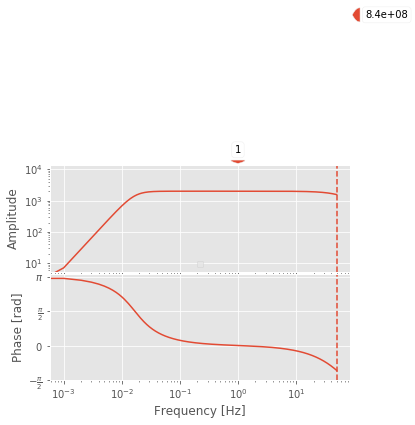

In [11]:
fig = channel.plot(min_freq=0.001, start_stage=1, end_stage=1)

You will see that the response continues smoothly to the Nyquist (and would continue beyond).

**Exercise:** Try plotting the other stages of the response and think about how they fit together
remembering that each acts as a filter.

## Timing

Seismic data are effectively useless without accurate timing information. Modern instruments use
GPS signals to get accurate (to microseconds) timing.  This means that we can accurately determine
seismic phase arrivals for location purposes.  However, keeping a GPS antenna running can be
power hungry, and for power-limited sites GPS "clocks" are often run in a cyled mode: they switch
on briefly to get a time fix, then turn off for a few minutes.  During this period of having the
clock off, the digitzier must rely on an internal clock to ensure that time is properly kept.
Digitzers therefore also have internal clocks to avoid "drift".

## Conclusion

This concludes our brief deomstration of digitizing continuous data.  It is worth pointing out that these ideas are not confined to seismic data: any continuous data can be sampled, and sampling does not have to be done in time.  For example, a line of gravity measurements is effectively a spatially sampled representation of the Earth's gravity field. If the transect has been regularly sampled then all of the ideas of Fourier Transforms can equally be applied to this dataset.  In the [next notebook](3_Fourier_Transforms.ipynb) we will look at how we compute the Fourier transform of seismic data.


Additional reading: Scherbaum, F., Of Poles and Zeros: Chapters 5 and 6